In [0]:
import tensorflow as tf
print(tf.__version__)

2.2.0


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

class MyModel(Model):
	    def __init__(self, units, classes, **kwargs):
	        super(MyModel, self).__init__(**kwargs)
	        self.d1 = Dense(units, activation='relu')
	        self.d2 = Dense(classes, activation='softmax')

	    def call(self, x):  
	        x = self.d1(x)
	        return self.d2(x)
    
mymodel = MyModel(16, 4, name='my_model')
mymodel.compile(loss='binary_crossentropy')
mymodel.build( (128, 8))

mymodel.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  144       
_________________________________________________________________
dense_1 (Dense)              multiple                  68        
Total params: 212
Trainable params: 212
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [0]:
# Build the model

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense_1 = Dense(64, activation='relu')
        self.dense_2 = Dense(10)

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        return x

class MyModel2(Model):
    def __init__(self):
        super(MyModel2, self).__init__()
        self.dense_1 = Dense(64, activation='relu')
        self.dense_2 = Dense(10)
        self.dropout = Dropout(.5)

    def call(self, inputs, training=True):
        x = self.dense_1(inputs)
        if training:
            x = self.dropout(x)
        x = self.dense_2(x)
        return x

class MyModel3(Model):
    def __init__(self):
        super(MyModel3, self).__init__()
        self.dense_1 = Dense(64, activation='relu')
        self.dense_2 = Dense(10)
        self.dense_3 = Dense(5)
        self.softmax = Softmax()

    def call(self, inputs):
        x = self.dense_1(inputs)
        y1 = self.dense_2(inputs)
        y2 = self.dense_3(y1)

        concat = concatenate([x,y2])
        return self.softmax(concat)

In [0]:
# Print the model summary

model = MyModel()
model(tf.random.uniform([1, 10]))
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  704       
_________________________________________________________________
dense_3 (Dense)              multiple                  650       
Total params: 1,354
Trainable params: 1,354
Non-trainable params: 0
_________________________________________________________________


In [0]:
model2 = MyModel2()
model2(tf.random.uniform([1,10]))
model2.build((1,10))
model2.summary()        

Model: "my_model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              multiple                  704       
_________________________________________________________________
dense_5 (Dense)              multiple                  650       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
Total params: 1,354
Trainable params: 1,354
Non-trainable params: 0
_________________________________________________________________


In [0]:
model3 = MyModel3()
model3(tf.random.uniform([1,10]))
model3.summary() 

Model: "my_model3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              multiple                  704       
_________________________________________________________________
dense_7 (Dense)              multiple                  110       
_________________________________________________________________
dense_8 (Dense)              multiple                  55        
_________________________________________________________________
softmax (Softmax)            multiple                  0         
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [0]:
# Create a custom layer

class MyLayer(Layer):

    def __init__(self, units, input_dims):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dims, units), initializer='random_normal')
        self.b = self.add_weight(shape=(units,), initializer='zeros')

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

dense_layer = MyLayer(3, 5)
x = tf.ones((1,5))       
print(x)
print(dense_layer.weights) 
print(dense_layer(x))

tf.Tensor([[1. 1. 1. 1. 1.]], shape=(1, 5), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.02244209, -0.01064816,  0.1354268 ],
       [-0.11704691,  0.00889495,  0.06586126],
       [-0.09331398,  0.02800617,  0.09303033],
       [-0.04598857, -0.01924081,  0.06296175],
       [-0.09163545,  0.01580499, -0.06370581]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]
tf.Tensor([[-0.3255428   0.02281714  0.29357436]], shape=(1, 3), dtype=float32)


In [0]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 2
non-trainable weights: 0


In [0]:
# Specify trainable weights

class MyLayer(Layer):

    def __init__(self, units, input_dims):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dims, units), 
                                 initializer='random_normal', trainable=False)
        self.b = self.add_weight(shape=(units,), initializer='zeros', trainable=False)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

dense_layer = MyLayer(3, 5)

In [0]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 0
non-trainable weights: 2


In [0]:
# Create a custom layer to accumulate means of output values

class MyLayerMean(Layer):

    def __init__(self, units, input_dims):
        super(MyLayerMean, self).__init__()
        self.w = self.add_weight(shape=(input_dims, units), initializer='random_normal')
        self.b = self.add_weight(shape=(units,), initializer='zeros')
        self.sum_activation = tf.Variable(initial_value=tf.zeros((units,)), 
                                          trainable=False)
        self.number_calls = tf.Variable(initial_value=0, trainable=False)

    def call(self, inputs):
        activations = tf.matmul(inputs, self.w) + self.b
        self.sum_activation.assign_add(tf.reduce_sum(activations, axis=0))
        self.number_calls.assign_add(inputs.shape[0])
        return activations, self.sum_activation / tf.cast(self.number_calls, tf.float32)

dense_layer = MyLayerMean(3, 5)

In [0]:
# Test the layer

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

y, activation_means = dense_layer(tf.ones((2, 5)))
print(activation_means.numpy())

[ 0.03602648 -0.00672022 -0.04202849]
[ 0.03602648 -0.00672022 -0.04202849]


In [0]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)


class MyLayer(Layer):

    def __init__(self, units, input_dims):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dims, units), 
                                 initializer='random_normal', trainable=False)
        self.b = self.add_weight(shape=(units,), 
                                 initializer='zeros', trainable=False)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

#### Implement the custom layers into a model

In [0]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()

    def call(self, inputs):
        # Define forward pass
        h = self.layer_1(inputs)
        # h = tf.nn.relu(h)
        # h = self.dropout_1(h)

        # h = self.layer_2(h)
        # h = tf.nn.relu(h)
        # h = self.dropout_2(h)
        
        # h = self.layer_3(h)
        # h = self.softmax(h)
        return h

In [0]:
type(tf.ones((1, 10000)))

tensorflow.python.framework.ops.EagerTensor

In [0]:
# Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
# model.summary()

tf.Tensor(
[[ -0.76041746   4.368413    -0.8154504   -3.2015417  -10.204496
   -1.1301198    1.0331945    2.2987735   -0.27766103  -2.4866056
    1.173135    -0.91078484  -3.7827725   -4.343778    -9.082628
   -9.420498    -3.1222246    2.6005077   -1.5889902    1.3460046
   -0.0298605    3.2928038    6.778238     3.6040325   -5.5816603
   -6.3998613    2.001384     0.12524003  -7.5391827    2.7760882
    3.2885878   -6.5205398   -0.9876097    1.8805653   -3.6972125
    1.761897     2.4590032   -6.4491615    2.5492024   -4.347492
    1.6009054    0.06714441   9.370401     3.3091362   -0.42244464
    2.1641278   -3.7818167    1.097631    -8.802247     3.082017
   -6.315705    -3.3636706    2.2820053   10.189365    -5.6801248
   -1.1519295    4.8377986    5.7155347   -8.046836    -0.5394838
   10.581318     2.0846777   -4.0721035    4.6322    ]], shape=(1, 64), dtype=float32)


***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

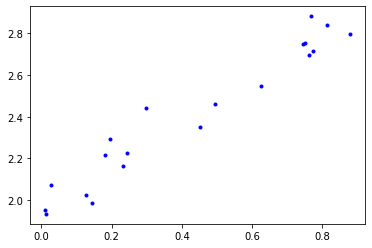

In [0]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [0]:
from tensorflow.keras.layers import Layer

In [0]:
# Build a custom layer for the linear regression model

class LinearLayer(Layer):

    def __init__(self):
        super(LinearLayer, self).__init__()

        self.w = self.add_weight(shape=(1,), 
                                 initializer=tf.keras.initializers.RandomNormal())
        self.b = self.add_weight(shape=(1,), 
                                 initializer=tf.keras.initializers.zeros())
        
    def call(self, inputs):
        return self.w * inputs + self.b

linear_regression = LinearLayer()
print(f'Linear reg : {linear_regression(x_train)}')
print(f'Linear weights : {linear_regression.weights}')

Linear reg : [-0.0004434  -0.02554508 -0.00428336 -0.01655839 -0.02503754 -0.00652898
 -0.00483894 -0.0078363  -0.00612301 -0.0273355  -0.02596873 -0.02575402
 -0.02947129 -0.0251693  -0.01514012 -0.00816817 -0.00089634 -0.02096443
 -0.01004521 -0.0003918 ]
Linear weights : [<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-0.0335792], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


#### Define the loss function

In [0]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 5.962152


#### Train and plot the model

In [0]:
# Implement a gradient descent training loop for the linear regression model

learningRate = 0.05
steps = 20

print(linear_regression.trainable_variables)

for i in range(steps):
    with tf.GradientTape() as tape:
        pred = linear_regression(x_train)
        loss = SquaredError(pred, y_train)

    if i == 1:
        print('LOSS :',loss.numpy())
        print('VARS :',[var.numpy() for var in linear_regression.trainable_variables])
    grad = tape.gradient(loss, linear_regression.trainable_variables)
    
    if i == 0:
        print('gradients', grad)

    linear_regression.w.assign_sub(learningRate * grad[0])
    linear_regression.b.assign_sub(learningRate * grad[1])

    print(f'Step : {i}, Loss : {loss.numpy()}')

[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-0.0335792], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]
gradients [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-2.2570186], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-4.8392115], dtype=float32)>]
Step : 0, Loss : 5.962152004241943
LOSS : 4.621869
VARS : [array([0.07927172], dtype=float32), array([0.24196057], dtype=float32)]
Step : 1, Loss : 4.621869087219238
Step : 2, Loss : 3.5832419395446777
Step : 3, Loss : 2.7783775329589844
Step : 4, Loss : 2.1546618938446045
Step : 5, Loss : 1.6713234186172485
Step : 6, Loss : 1.296767234802246
Step : 7, Loss : 1.0065094232559204
Step : 8, Loss : 0.7815768122673035
Step : 9, Loss : 0.6072664260864258
Step : 10, Loss : 0.47218483686447144
Step : 11, Loss : 0.3675026595592499
Step : 12, Loss : 0.2863779664039612
Step : 13, Loss : 0.2235085517168045
Step : 14, Loss : 0.1747857630252838
Ste

m:1,  trained m:[0.84559894]
b:2,  trained b:[1.8589005]


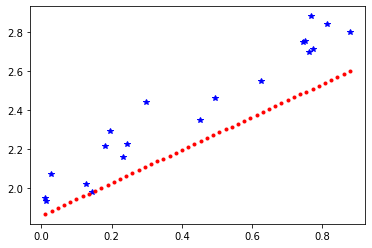

In [0]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.w.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b*')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.w*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [0]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [0]:
# Define the custom layers and model

class MyLayer(Layer):

    def __init__(self, units, input_dims):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dims, units), 
                                 initializer='random_normal')
        self.b = self.add_weight(shape=(units,), 
                                 initializer='zeros')

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)     

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()

    def call(self, inputs):
        # Define forward pass
        h = self.layer_1(inputs)
        h = tf.nn.relu(h)
        h = self.dropout_1(h)

        h = self.layer_2(h)
        h = tf.nn.relu(h)
        h = self.dropout_2(h)
        
        h = self.layer_3(h)
        h = self.softmax(h)
        return h           

In [0]:
model = MyModel(64, 10000, 64, 46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.05169966 0.02999633 0.00640598 0.00548897 0.02394713 0.01215977
  0.05133455 0.01670946 0.06556829 0.02257407 0.01993546 0.01666477
  0.00648258 0.00445724 0.01217728 0.00307419 0.02887812 0.01628843
  0.021133   0.00773139 0.00354142 0.01906608 0.01270891 0.02343998
  0.01900999 0.01462875 0.01505457 0.16480985 0.01530787 0.01933029
  0.03218789 0.03027378 0.02178647 0.01133325 0.00679659 0.0063422
  0.0197454  0.01177922 0.00504736 0.05655994 0.00349458 0.00444147
  0.01345724 0.0216147  0.01461009 0.0109254 ]], shape=(1, 46), dtype=float32)
Model: "my_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_5 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout_2 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_6 (MyLayer

#### Load the reuters dataset and define the class_names 

In [0]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

In [0]:
# print(len(class_names))
# np.unique(test_labels)
# train_labels = to_categorical(train_labels)
# test_labels = to_categorical(test_labels)

In [0]:
np.argmax(train_labels[0])

0

In [0]:
# Print the class of the first sample

print("Label: {}".format(class_names[(train_labels[0])]))

Label: earn


#### Get the dataset word index

In [0]:
print('len : ', len(train_data[0]))
print(train_data[0])

len :  87
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [0]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

In [0]:
# Print the first data example sentence

print(len(text_news))
print(text_news)

389
? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Preprocess the data

In [0]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer



In [0]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [0]:
# Define a function to compute the forward and backward pass
@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [0]:
# a = train_dataset.take(1)
# for x, y in a:
#     print(x)

In [0]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

no_epochs = 10
weight_decay = .005

for epoch in range(no_epochs):

    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.Accuracy()

    i=0
    for x, y in train_dataset:
        # optimize the model
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # compute the current loss
        epoch_loss_avg(loss_value)

        # compare pred label to actual label
        epoch_accuracy(to_categorical(y, num_classes=46), model(x))
        # epoch_accuracy(model(x), to_categorical(y))

    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print('Epoch : {}, Loss : {:.03f}, Accuracy : {:3.3%}'.format(
        epoch, epoch_loss_avg.result(), epoch_accuracy.result().numpy()
    ))
    
print("Duration :{:.3f}".format(time.time() - start_time))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch : 0, Loss : 2.120, Accuracy : 0.000%
Epoch : 1, Loss : 1.426, Accuracy : 0.000%
Epoch : 2, Loss : 1.178, Accuracy : 0.000%
Epoch : 3, Loss : 1.031, Accuracy : 0.001%
Epoch : 4, Loss : 0.904, Accuracy : 0.002%
Epoch : 5, Loss : 0.814, Accuracy : 0.004%
Epoch : 6, Loss : 0.747, Accuracy : 0.018%
Epoch : 7, Loss : 0.697, Accuracy : 0.019%
Epoch : 8, Loss : 0.644, Accuracy : 0.028%
Epoch : 9, Loss : 0.597, Accuracy : 0.052%
Duration :55.253


#### Evaluate the model

In [0]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [0]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [0]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 1.425
Test accuracy: 71.149%


#### Plot the learning curves

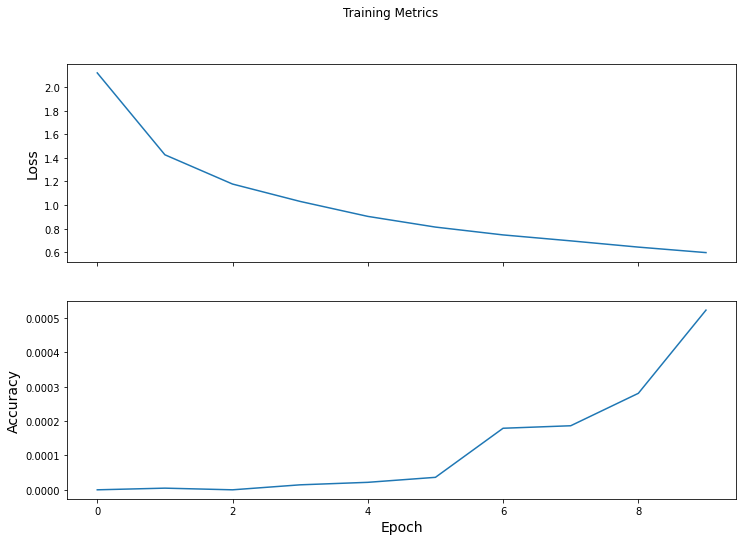

In [0]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [0]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: earn
     Label: earn


***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [0]:
# Initialize a new model

model = MyModel(64,10000, 64,46)

#### Redefine the grad function using the @tf.function decorator

In [0]:
# Use the @tf.function decorator

@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

#### Train the model

In [0]:
# Re-run the training loop

# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

no_epochs = 10
weight_decay = .005

for epoch in range(no_epochs):

    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.Accuracy()

    i=0
    for x, y in train_dataset:
        # optimize the model
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # compute the current loss
        epoch_loss_avg(loss_value)

        # compare pred label to actual label
        epoch_accuracy(to_categorical(y, num_classes=46), model(x))

    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print('Epoch : {}, Loss : {}, Accuracy {:.3%}'.format(
        epoch, epoch_loss_avg.result(), epoch_accuracy.result().numpy()
    ))
    
print("Duration :{:.3f}".format(time.time() - start_time))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch : 0, Loss : 1.7518573999404907, Accuracy 0.000%
Epoch : 1, Loss : 1.2949295043945312, Accuracy 0.005%
Epoch : 2, Loss : 1.1570078134536743, Accuracy 0.005%
Epoch : 3, Loss : 1.0257000923156738, Accuracy 0.014%
Epoch : 4, Loss : 0.9406846761703491, Accuracy 0.018%
Epoch : 5, Loss : 0.8546560406684875, Accuracy 0.055%
Epoch : 6, Loss : 0.8080902099609375, Accuracy 0.128%
Epoch : 7, Loss : 0.7629712224006653, Accuracy 0.158%
Epoch : 8, Loss : 0.7059006094932556, Accuracy 0.205%
Epoch : 9, Loss : 0.71

#### Print the autograph code

In [0]:
# Use tf.autograph.to_code to see the generated code

print(tf.autograph.to_code(grad.python_function))

def tf__grad(model, inputs, targets, wd):
    do_return = False
    retval_ = ag__.UndefinedReturnValue()
    with ag__.FunctionScope('grad', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        with tf.GradientTape() as tape:
            loss_value = ag__.converted_call(loss, (model, inputs, targets, wd), None, fscope)
        try:
            do_return = True
            retval_ = fscope.mark_return_value((loss_value, ag__.converted_call(tape.gradient, (loss_value, model.trainable_variables), None, fscope)))
        except:
            do_return = False
            raise
    (do_return,)
    return ag__.retval(retval_)



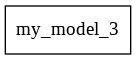

In [0]:
tf.keras.utils.plot_model(model, show_shapes=True)